<a href="https://colab.research.google.com/github/sachinHansak/Image-Classifier-with-CNN-Tensorflow-/blob/main/Image_clf_with_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tensorflow tensorflow-gpu opencv-python matplotlib

In [2]:
import tensorflow as tf
import os

In [3]:
import torch
torch.cuda.is_available()

True

In [4]:
# Set device (GPU if available, else CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## 2.Remove dodgy images

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [11]:
import cv2
import imghdr

In [12]:
data_dir = '/content/drive/MyDrive/data'

In [13]:
image_exts = ['jpeg','jpg', 'bmp', 'png']

In [14]:
for image_class in os.listdir(data_dir):
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try:
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts:
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e:
            print('Issue with image {}'.format(image_path))
            # os.remove(image_path)

In [15]:
img = cv2.imread(os.path.join('/content/drive/MyDrive/data', 'happy', '154006829.jpg'))

In [16]:
img.shape

(3744, 5616, 3)

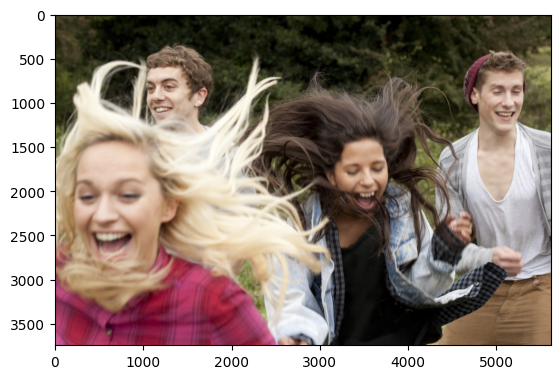

In [19]:
import matplotlib.pyplot as plt
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

## 3.Load the Data

In [23]:
tf.data.Dataset??

In [24]:
import numpy as np
from matplotlib import pyplot as plt

In [25]:
data = tf.keras.utils.image_dataset_from_directory('/content/drive/MyDrive/data')

Found 305 files belonging to 2 classes.


In [26]:
data_iterator = data.as_numpy_iterator()

In [27]:
data_iterator

In [28]:
# Get another batch from the iterator
batch = data_iterator.next()

In [29]:
batch[0].shape

(32, 256, 256, 3)

In [33]:
# Class 1 = Sad People
# Class 0 = Happy people
batch[1]

array([0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1,
       0, 0, 0, 0, 1, 1, 0, 0, 1, 1], dtype=int32)

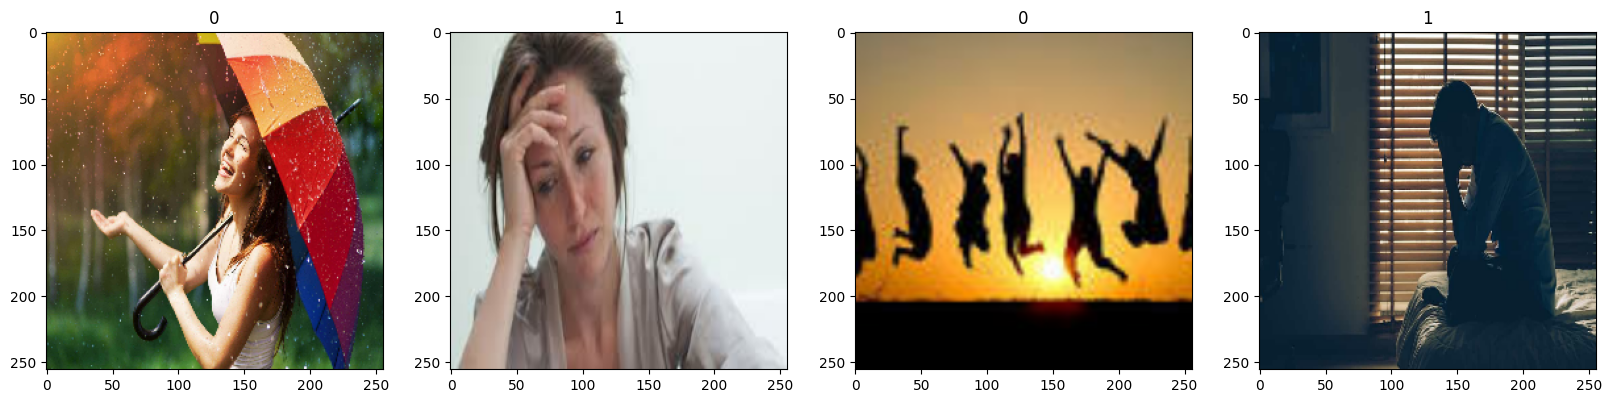

In [34]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

## 4.Preprocess the data

#### 4.1 Scale the data

In [35]:
data = data.map(lambda x,y: (x/255, y))

In [39]:
scaled_iterator = data.as_numpy_iterator()

In [40]:
batch = scaled_iterator.next()

In [42]:
batch[0].max()

1.0

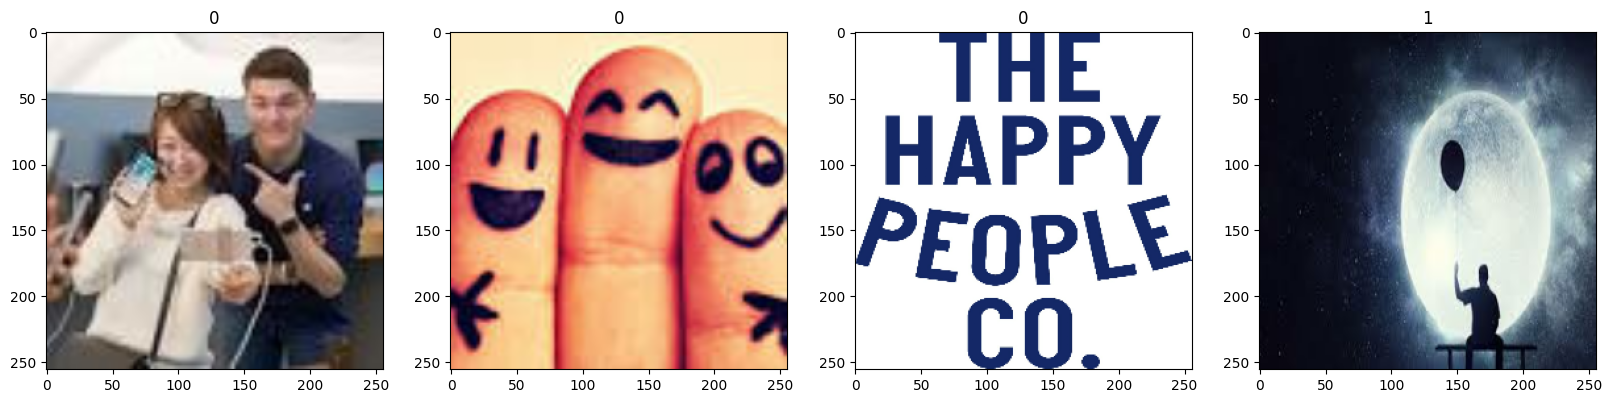

In [44]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img)
    ax[idx].title.set_text(batch[1][idx])

## 5.Split Data

In [45]:
len(data)

10

In [46]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)

In [50]:
train_size + val_size + test_size

10

In [51]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

In [53]:
len(train)

7

## 6.Build Deep Learning Model

In [54]:
train

<_TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [55]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [56]:
model = Sequential()

In [57]:
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [58]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [59]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 62, 62, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 30, 30, 16)        0

## 7.train

In [61]:
logdir='logs'

In [62]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [63]:
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20
7/7 [==============================] - 14s 587ms/step - loss: 0.9106 - accuracy: 0.5446 - val_loss: 0.6219 - val_accuracy: 0.7344
Epoch 2/20
7/7 [==============================] - 9s 913ms/step - loss: 0.6418 - accuracy: 0.7098 - val_loss: 0.6286 - val_accuracy: 0.6875
Epoch 3/20
7/7 [==============================] - 6s 582ms/step - loss: 0.6417 - accuracy: 0.6786 - val_loss: 0.5740 - val_accuracy: 0.7656
Epoch 4/20
7/7 [==============================] - 8s 757ms/step - loss: 0.5817 - accuracy: 0.7455 - val_loss: 0.5814 - val_accuracy: 0.7812
Epoch 5/20
7/7 [==============================] - 8s 912ms/step - loss: 0.4858 - accuracy: 0.7500 - val_loss: 0.3931 - val_accuracy: 0.8750
Epoch 6/20
7/7 [==============================] - 8s 593ms/step - loss: 0.4159 - accuracy: 0.8571 - val_loss: 0.3186 - val_accuracy: 0.8750
Epoch 7/20
7/7 [==============================] - 8s 913ms/step - loss: 0.2935 - accuracy: 0.8661 - val_loss: 0.2441 - val_accuracy: 0.9375
Epoch 8/20
7/7 [===

In [ ]:
hist.history

## 8. Plot the Performance

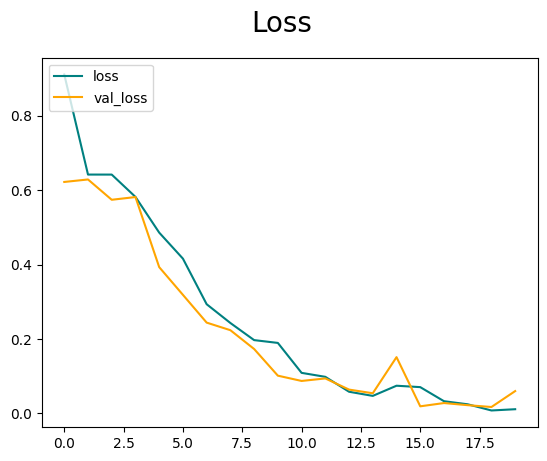

In [65]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

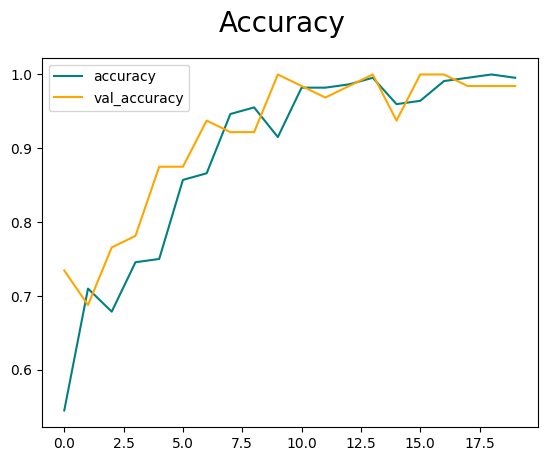

In [66]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

## 9.Evaluate

In [67]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [68]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [69]:
for batch in test.as_numpy_iterator():
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 [==============================] - 0s 450ms/step


In [74]:
print(f'Precision:{pre.result().numpy()}, Recall:{re.result().numpy()}, Accuracy:{acc.result().numpy()}')

Precision:1.0, Recall:1.0, Accuracy:1.0


## 10.Test

In [78]:
import cv2
import matplotlib.pyplot as plt

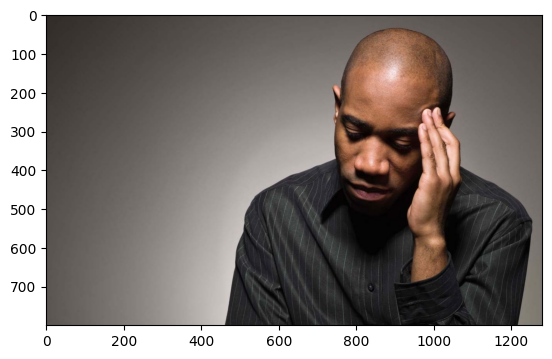

In [86]:
img = cv2.imread(os.path.join('/content/drive/MyDrive', 'happy', '/content/drive/MyDrive/sad_one.jpg'))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

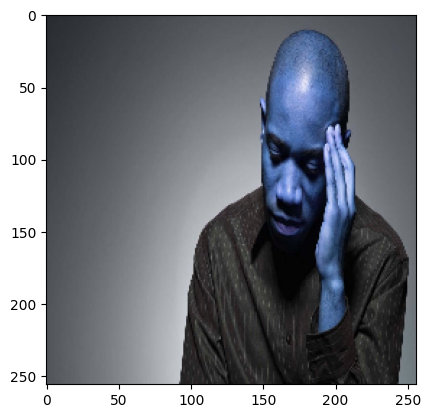

In [87]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [88]:
yhat = model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 18ms/step


In [89]:
yhat

array([[0.9818325]], dtype=float32)

In [90]:
if yhat > 0.5:
    print(f'Predicted class is Sad')
else:
    print(f'Predicted class is Happy')

Predicted class is Sad


## 11.Save the model

In [93]:
from tensorflow.keras.models import load_model

In [94]:
model.save(os.path.join('models','imageclassifier.h5'))

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [96]:
new_model = load_model('/content/models/imageclassifier.h5')

In [97]:
new_model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 116ms/step


array([[0.9818325]], dtype=float32)

In [98]:
if yhat > 0.5:
    print(f'Predicted class is Sad')
else:
    print(f'Predicted class is Happy')

Predicted class is Sad
